# Collaborative Filtering Based Recommender Systems using Low Rank Matrix Factorization(User & Movie Embeddings) & Neural Network in Keras.

## 1) Exploring the Data
### 1.1) Importing Various Modules

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense , merge
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau


from keras.layers.merge import dot
from keras.models import Model


# specifically for deeplearning.
from keras.layers import Dropout, Flatten,Activation,Input,Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
from IPython.display import SVG
 
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image


#TL pecific modules
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


### 1.2) Reading the CSV file

In [2]:
train=pd.read_csv(r'movielens100k/ratings.csv')
print('Length of DataSet : ' + str(len(train)))

FileNotFoundError: [Errno 2] File b'ratings.csv' does not exist: b'ratings.csv'

I am using the movie-lens-100K data. Note that this file contains the ratings given by our set of users to different movies. In all it contains total 100K ratings; to be exact 1000004.

In [3]:
df=train.copy()
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### 1.3) Exploring the dataset

In [4]:
print(df['userId'].unique())
print("Length of Unique ID's : " + str(len(df['userId'].unique())))

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [5]:
print(df['movieId'].unique())
print('Number of Different movies : ' + str(len(df['movieId'].unique())))

[  31 1029 1061 ...  129 4736 6425]
Number of Different movies : 9066


Note that for 671 users and 9066 movies we can have a maximum of 671*9066 = 6083286 ratings. But note that we have only 100004 ratings with us. Hence the utility matrix has only about 1.6 % of the total values. Thus it can be concluded that it is quite sparse. This limits the use of some algorithms. Hence we will create embeddings for them later.

In [6]:
print('Number of NULL places in userId column : ' + str(df['userId'].isnull().sum()))
print('Number of NULL places in movieId column : ' + str(df['movieId'].isnull().sum()))
print('Number of NULL places in rating column : ' + str(df['rating'].isnull().sum()))

Number of NULL places in userId column : 0
Number of NULL places in movieId column : 0
Number of NULL places in rating column : 0


In [7]:
print('Minimum Ratings : ' + str(df['rating'].min())) # minimum rating
print('Maximum Ratings : ' + str(df['rating'].max())) # maximum rating

Minimum Ratings : 0.5
Maximum Ratings : 5.0


## 2) Preparing the data

### 2.1) Encoding the columns

In [0]:
df.userId = df.userId.astype('category').cat.codes.values
df.movieId = df.movieId.astype('category').cat.codes.values

In [9]:
df['userId'].value_counts(ascending=True)

0        20
208      20
248      20
324      20
437      20
309      20
603      20
398      20
667      20
336      20
497      20
220      20
13       20
288      20
34       20
295      20
650      20
75       20
484      20
582      20
443      20
539      20
483      20
447      20
656      20
444      20
318      20
637      20
355      21
63       21
       ... 
528     604
357     617
653     626
118     641
305     645
474     655
261     676
101     678
231     682
460     696
517     707
456     713
22      726
387     792
471     830
211     876
212     910
579     922
508     923
293     947
29     1011
310    1019
379    1063
467    1291
451    1340
72     1610
14     1700
623    1735
563    1868
546    2391
Name: userId, Length: 671, dtype: int64

### 2.2) Creating the Utility Matrix

In [10]:
# creating utility matrix.
index=list(df['userId'].unique())
columns=list(df['movieId'].unique())
index=sorted(index)
columns=sorted(columns)
 
util_df=pd.pivot_table(data=df,values='rating',index='userId',columns='movieId')
# Nan implies that user has not rated the corressponding movie.

print(util_df)

movieId  0     1     2     3     4     5     ...  9060  9061  9062  9063  9064  9065
userId                                       ...                                    
0         NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN
1         NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN
2         NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN
3         NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN
4         NaN   NaN   4.0   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN
5         NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN
6         3.0   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN
7         NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN
8         4.0   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN
9         NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   Na

#### BREAKING IT DOWN--
1) This is the utility matrix; for each of the 671 users arranged rowwise; each column shows the rating of the movie given by a particular user.

2) Note that majority of the matrix is filled with 'Nan' which shows that majority of the movies are unrated by many users.

3) For each movie-user pair if the entry is NOT 'Nan' the vaue indicates the rating given by user to that corressponding movie.

4) For now I am gonna fill the 'Nan' value with value '0'. But note that this just is just indicative, a 0 implies NO RATING and doesn't mean that user has rated 0 to that movie. It doesn't at all represent any rating.

In [11]:
util_df.fillna(0)

movieId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9026,9027,9028,9029,9030,9031,9032,9033,9034,9035,9036,9037,9038,9039,9040,9041,9042,9043,9044,9045,9046,9047,9048,9049,9050,9051,9052,9053,9054,9055,9056,9057,9058,9059,9060,9061,9062,9063,9064,9065
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.3) Creating Training and Validation Sets.

In [0]:
# x_train,x_test,y_train,y_test=train_test_split(df[['userId','movieId']],df[['rating']],test_size=0.20,random_state=42)
users = df.userId.unique()
movies = df.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [13]:
df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(df)) < 0.8
train = df[split]
valid = df[~split]
print(train.shape , valid.shape)

(80073, 4) (19931, 4)


## 3) Matrix Factorization

Here comes the main part!!!
1) Now we move on to the crux of the notebook ie Matrix Factorization. In matrix facorization, we basically break a matrix into usually 2 smaller matrices each with smaller dimensions. these matrices are oftem called 'Embeddings'. We can have variants of Matrix Factorizartion-> 'Low Rank MF' , 'Non-Negaive MF' (NMF) and so on..

2) Here I have used the so called 'Low Rank Matrix Factorization'. I have created embeddings for both user as well as the item; movie in our case. The number of dimensions or the so called 'Latent Factors' in the embeddings is a hyperparameter to deal with in this implementation of Collaborative Filtering.

### 3.1) Creating the Embeddings ,Merging and Making the Model from Embeddings

In [15]:
n_movies=len(df['movieId'].unique())
n_users=len(df['userId'].unique())
n_latent_factors=64  # hyperparamter to deal with.
print(n_movies)
print(n_users)

9066
671


In [16]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')

In [17]:
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_embedding.shape

TensorShape([Dimension(None), Dimension(1), Dimension(64)])

In [18]:
user_vec =Flatten(name='FlattenUsers')(user_embedding)
user_vec.shape

TensorShape([Dimension(None), Dimension(None)])

In [19]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)
movie_vec

<tf.Tensor 'FlattenMovies/Reshape:0' shape=(?, ?) dtype=float32>

In [20]:
sim=dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)
model =keras.models.Model([user_input, movie_input],sim)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        42944       user_input[0][0]                 
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 64)        580224      movie_input[0][0]                
___________________________________________________________________________________________

#### BREAKING IT DOWN--
1) First we need to create embeddings for both the user as well as the item or movie. For this I have used the Embedding layer from keras.

2) Specify the input expected to be embedded (Both in user and item embedding). The use a Embedding layer which expects the no of latent factors in the resulting embedding and also the no of users or items.

3) Then we take the 'Dot-Product' of both the embeddings using the 'merge' layer. Note that 'dot-product' is just a measure of simalrity and we can use any other mode like 'mulitply' or 'cosine simalarity' or 'concatenate' etc...

4) Lastly we make a Keras model from the specified details.

### 3.2) Compiling the Model

In [21]:
model.compile(optimizer=Adam(lr=1e-4),loss='mse')

Note that the metrics used is 'Mean squared Error'. Our aim is to minimize the mse on the training set ie over the values which the user has rated (100004 ratings).

In [0]:
train.shape
batch_size=128
epochs=50

### 3.3) Fitting on Training set & Validating on Validation Set.

In [23]:
History = model.fit([train.userId,train.movieId],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.userId,valid.movieId],
                                                                valid.rating),verbose = 1)




Train on 80073 samples, validate on 19931 samples
Epoch 1/50





80073/80073 [==============================] - 8s 98us/step - loss: 13.6815 - val_loss: 13.6551
Epoch 2/50
80073/80073 [==============================] - 3s 41us/step - loss: 13.6697 - val_loss: 13.6498
Epoch 3/50
80073/80073 [==============================] - 3s 39us/step - loss: 13.6452 - val_loss: 13.6234
Epoch 4/50
80073/80073 [==============================] - 3s 39us/step - loss: 13.5747 - val_loss: 13.5222
Epoch 5/50
80073/80073 [==============================] - 3s 39us/step - loss: 13.3722 - val_loss: 13.2310
Epoch 6/50
80073/80073 [==============================] - 3s 39us/step - loss: 12.9046 - val_loss: 12.6199
Epoch 7/50
80073/80073 [==============================] - 3s 39us/step - loss: 12.0796 - val_loss: 11.6522
Epoch 8/50
80073/80073 [==============================] - 3s 39us/step - loss: 10.9245 - val_loss: 10.4128
Epoch 9/50
80073/80073 [==============================] - 3s 39us/step - loss: 9.5647 

## 4) Evaluating the Model Performance

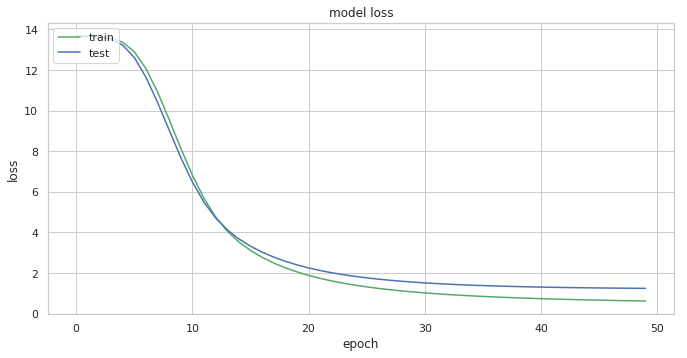

In [24]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## 5) Using a Neural Network

#### Now let us focus on the other main thing!!! Using a NN to matrix factorization.
1) Note that this way is not much different from the previous approach.

2) The main difference is that we have used Fully Connected layers as well as the Dropout layers and the BatchNormalization layers.

3) The number of units and the number of layers etc.. are the hyperparametrs here as in a traditional neural network.

### 5.1) Creating the Embeddings

Note that I have used 50 latent factors as that seems to give reasonable performance. Furhter tuning and careful optimization can give even better results.

In [0]:
n_latent_factors=50
n_movies=len(df['movieId'].unique())
n_users=len(df['userId'].unique())

In [26]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec=Flatten(name='FlattenUsers')(user_embedding)
user_vec=Dropout(0.40)(user_vec)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)
movie_vec=Dropout(0.40)(movie_vec)

In [0]:
sim=dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)

### 5.2) Specifying the Model architecture

In [29]:
nn_inp=Dense(96,activation='relu')(sim)
nn_inp=Dropout(0.4)(nn_inp)
nn_inp=BatchNormalization()(nn_inp)
nn_inp=Dense(1,activation='relu')(nn_inp)
nn_model =keras.models.Model([user_input, movie_input],nn_inp)
nn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        33550       user_input[0][0]                 
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 50)        453300      movie_input[0][0]                
____________________________________________________________________________________________

### 5.3) Compiling the Model

In [0]:
nn_model.compile(optimizer=Adam(lr=1e-3),loss='mse')

In [0]:
batch_size=128
epochs=20

### 5.4) Fitting on Training set & Validating on Validation Set.

In [32]:
History = nn_model.fit([train.userId,train.movieId],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.userId,valid.movieId],
                                                                 valid.rating),verbose = 1)

Train on 80073 samples, validate on 19931 samples
Epoch 1/20
80073/80073 [==============================] - 6s 70us/step - loss: 2.3214 - val_loss: 1.1417
Epoch 2/20
80073/80073 [==============================] - 5s 63us/step - loss: 1.1147 - val_loss: 1.1426
Epoch 3/20
80073/80073 [==============================] - 5s 62us/step - loss: 1.1056 - val_loss: 1.1281
Epoch 4/20
80073/80073 [==============================] - 5s 63us/step - loss: 1.0220 - val_loss: 1.1058
Epoch 5/20
80073/80073 [==============================] - 5s 63us/step - loss: 0.9370 - val_loss: 1.1068
Epoch 6/20
80073/80073 [==============================] - 5s 62us/step - loss: 0.8679 - val_loss: 1.0927
Epoch 7/20
80073/80073 [==============================] - 5s 63us/step - loss: 0.8173 - val_loss: 1.0795
Epoch 8/20
80073/80073 [==============================] - 5s 62us/step - loss: 0.7704 - val_loss: 1.0509
Epoch 9/20
80073/80073 [==============================] - 5s 63us/step - loss: 0.7328 - val_loss: 1.0820
Epoch

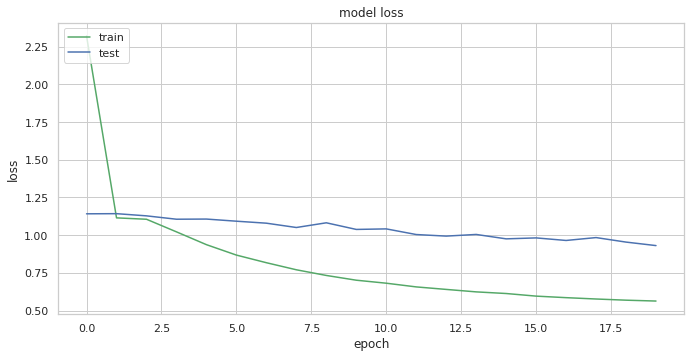

In [33]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()